## 3. Cosmic star formation history

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.integrate import quad
from astropy import constants as const
from scipy.interpolate import interp1d
from astropy.table import Table, Column
from astropy import units as u


#### (a) Calculate the age of the Universe (”cosmic time”) for each of these redshifts

In [111]:
# load data and assign to astropy tables

data1 = {
    'z': [0.1, 0.35, 0.6, 0.85, 1.25, 1.75, 2.25, 3.25, 4.5, 5.9, 7.4],
    'log_psi': [-1.80, -1.49, -1.34, -1.08, -0.96, -0.87, -0.83, -1.09, -1.42, -1.65, -1.96]
}

data1['log_psi'] = data1['log_psi'] * (u.M_sun / u.yr / u.Mpc**3)

table1 = Table(data1)

data2 = {
    'z': [0.1, 0.35, 0.6, 0.8, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 5.0, 7.5],
    'log_rho': [8.60, 8.58, 8.50, 8.52, 8.30, 8.09, 7.90, 7.67, 7.58, 7.23, 6.79, 6.12]
}

data2['log_rho'] = data2['log_rho'] * (u.M_sun / u.Mpc**3)

table2 = Table(data2)


In [112]:
# calculate the cosmic time for each redshift

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmic_time = [cosmo.age(z).to(u.Gyr) for z in table1['z']]

table1['cosmic_time'] = cosmic_time
print(table1['z','cosmic_time'])

 z      cosmic_time    
            Gyr        
---- ------------------
 0.1 12.165686389517036
0.35  9.602745844922444
 0.6  7.757289583942854
0.85  6.398478063082306
1.25  4.879756975473814
1.75  3.661772834563974
2.25 2.8699206566349504
3.25  1.930799913977016
 4.5 1.3150512164597155
 5.9  0.936936658844834
 7.4 0.6978999719386239


In [113]:
table2['cosmic_time'] =[cosmo.age(z).to(u.Gyr) for z in table2['z']]
print(table2['z','cosmic_time'])    

 z      cosmic_time    
            Gyr        
---- ------------------
 0.1 12.165686389517036
0.35  9.602745844922444
 0.6  7.757289583942854
 0.8  6.639428423211341
1.25  4.879756975473814
1.75  3.661772834563974
2.25 2.8699206566349504
2.75  2.324329959455381
3.25  1.930799913977016
3.75  1.636412421930824
 5.0 1.1547579107574137
 7.5 0.6856360315498223


#### (b) Plot the log ψ datapoints against cosmic time.

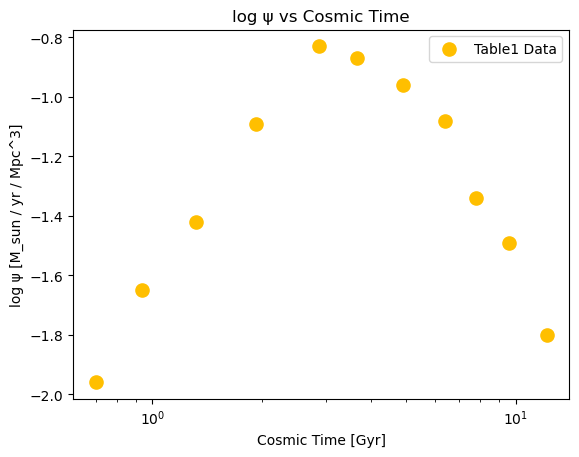

In [114]:
plt.scatter(table1['cosmic_time'], table1['log_psi'], color='#FFBF00', s=90, label='Table1 Data')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('log ψ [M_sun / yr / Mpc^3]')
plt.xscale('log')
plt.title('log ψ vs Cosmic Time')
plt.legend()
plt.show()

#### (c) Match a fitting formula to the data. 

Fitted parameters: A1 = 51.752, z1 = 0.558, A2 = 1.667, z2 = 1.685
R-squared: 0.9810087026527088


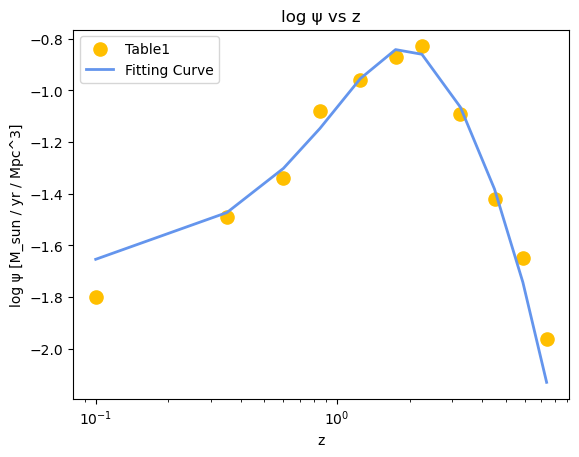

In [115]:
def psi_function(z, A1, z1, A2, z2):
    return 1 / (A1 * np.exp(-z / z1) + A2 * np.exp(z / z2))

table1['psi'] = 10**table1['log_psi']
popt, pcov = curve_fit(psi_function, table1['z'], table1['psi'],p0=[1, -1, 1, -1])

A1, z1, A2, z2 = popt

psi_fit = psi_function(table1['z'], *popt)

slope, intercept, r_value, p_value, std_err = linregress(table1['psi'], psi_fit)
r_squared = r_value**2

print(f"Fitted parameters: A1 = {A1:.3f}, z1 = {z1:.3f}, A2 = {A2:.3f}, z2 = {z2:.3f}") 
print(f"R-squared: {r_squared}")

plt.scatter(table1['z'], table1['log_psi'], color='#FFBF00', s=90,label='Table1')
plt.plot(table1['z'], np.log10(psi_function(table1['z'], *popt)), color='#6495ED',linewidth=2,label='Fitting Curve')
plt.xlabel('z')
plt.xscale('log')
plt.ylabel('log ψ [M_sun / yr / Mpc^3]')
plt.title('log ψ vs z')
plt.legend()
plt.show()




##### The fitted equation is
$$ \psi(z) = \frac{1}{51.752 \exp(-z/0.558) + 1.667 \exp(z/1.685)} $$

#### (d) Integrate this fitted relation to predict the evolving stellar mass density.

$$\rho_{*}(z) = (1 - R) \int_{z}^{\infty} \frac{\psi(z')}{H(z')(1 + z')} \, dz'$$

/var/folders/6m/zf_f5yss4dxc7yj9tl4kmfnc0000gn/T/ipykernel_1470/3008863655.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rho_star[i], _ = quad(integrand, z, np.inf, args=(psi_func))
/var/folders/6m/zf_f5yss4dxc7yj9tl4kmfnc0000gn/T/ipykernel_1470/3008863655.py:24: RuntimeWarning: invalid value encountered in log10
  table2['log rho_star'] = np.log10(rho_star_fit(table2['z']))


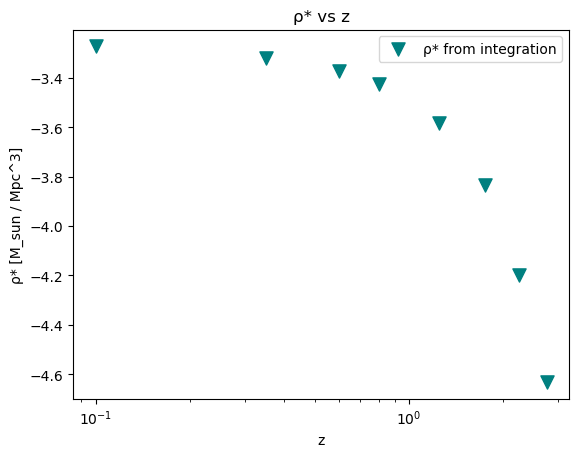

In [116]:
H0 = 70 
Om0 = 0.3
R = 0.27  # return fraction given in the article

def H(z):
    return H0 * np.sqrt(Om0 * (1 + z)**3 + (1 - Om0))

def integrand(z, psi_func):
    return psi_func(z) / (H(z) * (1 + z))

rho_star = np.zeros(len(table1['z']))

# interpolate the fitted psi function
psi_func = interp1d(table1['z'], psi_fit, fill_value='extrapolate')

# integrate the psi function to get rho_star
for i, z in enumerate(table1['z']):
    rho_star[i], _ = quad(integrand, z, np.inf, args=(psi_func))
rho_star *= (1 - R) 

# interpolate the rho_star function
rho_star_fit = interp1d(table1['z'], rho_star, fill_value='extrapolate')

table2['log rho_star'] = np.log10(rho_star_fit(table2['z']))

plt.scatter(table2['z'], table2['log rho_star'], color='Teal', s=90,marker='v',label='ρ* from integration')
plt.xlabel('z')
plt.xscale('log')
plt.ylabel('ρ* [M_sun / Mpc^3]')
plt.title('ρ* vs z')
plt.legend()
plt.show()




#### (e) Plot the datapoints of log ρ∗ against cosmic time and overplot your integrated fitted relation. Compare with Fig. 11 in the review.

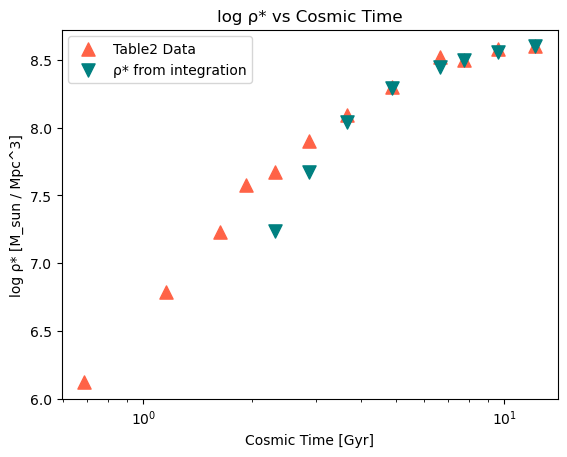

In [119]:
# add integration constant to rho_star to match the first data point
plt.scatter(table2['cosmic_time'], table2['log_rho'], color='Tomato', s=90,marker='^',label='Table2 Data')
plt.scatter(table2['cosmic_time'], table2['log rho_star']-table2['log rho_star'][0]+table2['log_rho'][0], color='Teal', s=90,marker='v',label='ρ* from integration')
plt.xlabel('Cosmic Time [Gyr]')
plt.xscale('log')
plt.ylabel('log ρ* [M_sun / Mpc^3]')
plt.title('log ρ* vs Cosmic Time')
plt.legend()
plt.show()



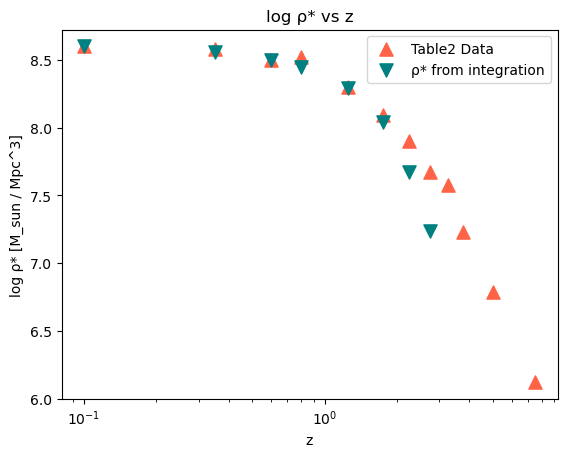

In [118]:
# plot again with redshift

plt.scatter(table2['z'], table2['log_rho'], color='Tomato', s=90,marker='^',label='Table2 Data')
plt.scatter(table2['z'], table2['log rho_star']-table2['log rho_star'][0]+table2['log_rho'][0], color='teal', s=90,marker='v',label='ρ* from integration')
plt.xlabel('z')
plt.xscale('log')
plt.ylabel('log ρ* [M_sun / Mpc^3]')
plt.title('log ρ* vs z')
plt.legend()
plt.show()

#### The integrated fitted relation is almost the same as the data points, except that it falls slightly below for smaller cosmic time, or larger z. Compared to Figure 11 from the review, it is clear that the overall trend is very similar.However, one noticeable differece is that the stellar mass density integrated from the fitted star formation history falls steeper than given data points in our result, whereas the former is slightly above the latter in the case of the Figure 11.